In [1]:
import pyfolio as pf
import sys
sys.path.append('/home/chris/repos/financial_analysis/')
import pandas as pd

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from credentials import *

/home/chris/anaconda3/lib/python3.6/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/chris/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import requests
import json
import pprint

url = "https://www.alphavantage.co/query"
outFile = '../newfile.csv'
function = "TIME_SERIES_DAILY"
symbol = "^GDAXI"
api_key = key

data = { "function": function, 
         "symbol": symbol, 
         "apikey": api_key,
         "outputsize": 'compact',
         "datatype": 'csv'} 
page = requests.get(url, params = data)
#pprint.pprint(page.json())

with open(outFile, 'w') as oF:
    oF.write(page.text)

In [3]:
dax = 'DAX'
df = pd.read_csv('../newfile.csv',usecols=["timestamp", "close"]).rename(columns={'close' : 'close_'+dax})


In [4]:
stock_rets = df.close_DAX

In [5]:
out_of_sample = df.close_DAX.index[-40]

In [6]:
out_of_sample 

60

In [13]:
pf.create_bayesian_tear_sheet(stock_rets, live_start_date=out_of_sample)

ImmediateDeprecationError: 
Yahoo Actions has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues


In [ ]:
import sys
sys.path.append('C:\Python27\Lib\site-packages')

import cvxopt

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [10]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

Text(0,0.5,'returns')

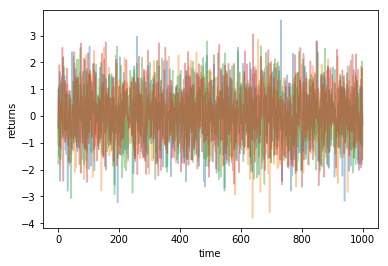

In [11]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

In [14]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print( rand_weights(n_assets))
print( rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


In [15]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [18]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for i in range(n_portfolios)
])

Text(0.5,1,'Mean and standard deviation of returns of randomly generated portfolios')

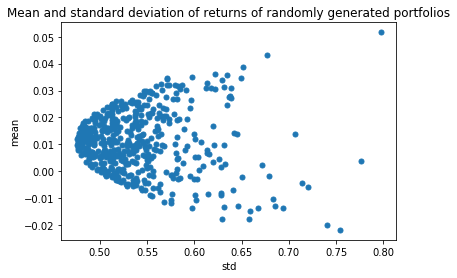

In [19]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

In [ ]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks



In [ ]:
'''weights, returns, risks = optimal_portfolio(return_vec)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')'''

In [11]:
import zipline.utils.factory as zp
#from zipline.utils.factory import load_bars_from_yahoo
end = pd.Timestamp.utcnow()
start = end - 2500 * pd.tseries.offsets.BDay()

data = zp.load_bars_from_yahoo(stocks=['IBM', 'GLD', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY'], start=start, end=end)

AttributeError: module 'zipline.utils.factory' has no attribute 'load_bars_from_yahoo'

In [16]:
# Research environment functions
import quantopian
#from quantopian.research import prices, symbols

# Pandas library: https://pandas.pydata.org/
import pandas as pd

# Query historical pricing data for AAPL
aapl_close = prices(
    assets=symbols('AAPL'),
    start='2013-01-01',
    end='2016-01-01',
)

# Compute 20 and 50 day moving averages on
# AAPL's pricing data
aapl_sma20 = aapl_close.rolling(20).mean()
aapl_sma50 = aapl_close.rolling(50).mean()

# Combine results into a pandas DataFrame and plot
pd.DataFrame({   
    'AAPL': aapl_close,
    'SMA20': aapl_sma20,
    'SMA50': aapl_sma50
}).plot(
    title='AAPL Close Price / SMA Crossover'
);

ModuleNotFoundError: No module named 'quantopian'